# CMA and DEMA Algorithms for Micro-Aethalometer Data

## 1. Introduction and Background

This notebook implements two post-processing algorithms for micro-aethalometer data:
 
1. **Centered Moving Average (CMA)**: A smoothing technique that incorporates data points both before and after each measurement to reduce noise while preserving microenvironmental characteristics.

2. **Double Exponentially Weighted Moving Average (DEMA)**: A smoothing approach that reduces noise-induced artifacts while limiting lag, especially useful for source apportionment calculations.

Both of these methods have been shown to outperform the Optimized Noise-reduction Algorithm (ONA) for newer dual-spot aethalometers, as demonstrated in recent research by Liu et al. (2021) and Mendoza et al. (2024).

## 2. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import seaborn as sns
from IPython.display import display

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 3. Load and Explore the Data

First, let's load the Aethalometer data and examine its structure.

In [2]:
# Define the file path - replace with your actual file path
file_path = "/Users/ahzs645/Library/CloudStorage/GoogleDrive-ahzs645@gmail.com/My Drive/University/Research/Grad/UC Davis Ann/NASA MAIA/Data/Aethelometry Data/Jacros_MA350_1-min_2022-2024_Cleaned.csv"
# Load the data
data = pd.read_csv(file_path)

# Display basic information about the dataset
print(f"Dataset shape: {data.shape}")
print("\nColumn names:")
print(data.columns.tolist())

# Display the first few rows
print("\nFirst few rows of the dataset:")
display(data.head())

# Check for the presence of BC columns for each wavelength
wavelengths = ['UV', 'Blue', 'Green', 'Red', 'IR']
for wavelength in wavelengths:
    bc_col = f"{wavelength} BC1"
    
    if bc_col in data.columns:
        print(f"\n{wavelength} wavelength data:")
        print(f"  BC range: {data[bc_col].min()} to {data[bc_col].max()} ng/m³")
        print(f"  Negative BC values: {(data[bc_col] < 0).sum()} ({(data[bc_col] < 0).sum() / len(data) * 100:.2f}%)")
    else:
        print(f"\nWarning: {wavelength} data columns not found")

# Check the time resolution
if 'Timebase (s)' in data.columns:
    timebase = data['Timebase (s)'].iloc[0]
    print(f"\nInstrument timebase: {timebase} seconds")
else:
    print("\nTimebase column not found")


Dataset shape: (1095086, 77)

Column names:
['Serial number', 'Time (UTC)', 'Datum ID', 'Session ID', 'Data format version', 'Firmware version', 'App version', 'Timezone offset (mins)', 'Date local (yyyy/MM/dd)', 'Time local (hh:mm:ss)', 'GPS lat (ddmm.mmmmm)', 'GPS long (dddmm.mmmmm)', 'GPS speed (km/h)', 'GPS sat count', 'Timebase (s)', 'Status', 'Battery remaining (%)', 'Accel X', 'Accel Y', 'Accel Z', 'Tape position', 'Flow setpoint (mL/min)', 'Flow total (mL/min)', 'Flow1 (mL/min)', 'Flow2 (mL/min)', 'Sample temp (C)', 'Sample RH (%)', 'Sample dewpoint (C)', 'Internal pressure (Pa)', 'Internal temp (C)', 'Optical config', 'UV Sen1', 'UV Sen2', 'UV Ref', 'UV ATN1', 'UV ATN2', 'UV K', 'Blue Sen1', 'Blue Sen2', 'Blue Ref', 'Blue ATN1', 'Blue ATN2', 'Blue K', 'Green Sen1', 'Green Sen2', 'Green Ref', 'Green ATN1', 'Green ATN2', 'Green K', 'Red Sen1', 'Red Sen2', 'Red Ref', 'Red ATN1', 'Red ATN2', 'Red K', 'IR Sen1', 'IR Sen2', 'IR Ref', 'IR ATN1', 'IR ATN2', 'IR K', 'UV BC1', 'UV BC2',

,Serial number,Time (UTC),Datum ID,Session ID,Data format version,Firmware version,App version,Timezone offset (mins),Date local (yyyy/MM/dd),Time local (hh:mm:ss),...,Green BC1,Green BC2,Green BCc,Red BC1,Red BC2,Red BCc,IR BC1,IR BC2,IR BCc,Readable status
0,MA350-0238,2022-04-12T09:46:01Z,26133,12,1,1.1,1.4,0,2022-04-12,9:46:01 AM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MA350-0238,2022-04-12T09:47:01Z,26134,12,1,1.1,1.4,0,2022-04-12,9:47:01 AM,...,18208.0,17175.0,18208.0,17685.0,16620.0,17685.0,18120.0,16389.0,18120.0,NaN
2,MA350-0238,2022-04-12T09:48:01Z,26135,12,1,1.1,1.4,0,2022-04-12,9:48:01 AM,...,11178.0,10474.0,11178.0,10834.0,10057.0,10834.0,10784.0,9686.0,10784.0,NaN
3,MA350-0238,2022-04-12T09:49:01Z,26136,12,1,1.1,1.4,0,2022-04-12,9:49:01 AM,...,6216.0,6134.0,6216.0,6145.0,5773.0,6145.0,6263.0,5908.0,6263.0,NaN
4,MA350-0238,2022-04-12T09:50:01Z,26137,12,1,1.1,1.4,0,2022-04-12,9:50:01 AM,...,6499.0,6252.0,6499.0,6231.0,5983.0,6231.0,6411.0,6101.0,6411.0,NaN



UV wavelength data:
  BC range: -564.0 to 352716.0 ng/m³
  Negative BC values: 1116 (0.10%)

Blue wavelength data:
  BC range: -583.0 to 380922.0 ng/m³
  Negative BC values: 791 (0.07%)

Green wavelength data:
  BC range: -679.0 to 388015.0 ng/m³
  Negative BC values: 1318 (0.12%)

Red wavelength data:
  BC range: -815.0 to 406348.0 ng/m³
  Negative BC values: 919 (0.08%)

IR wavelength data:
  BC range: -1470.0 to 432792.0 ng/m³
  Negative BC values: 1104 (0.10%)

Instrument timebase: 60 seconds


## 4. CMA Algorithm Implementation
 
The Centered Moving Average is a smoothing technique that uses data points both before and after each measurement. This helps maintain the central trend without introducing lag or phase shifts.

In [3]:
def apply_cma(data, wavelength='Blue', window_size=None):
    """
    Apply the Centered Moving Average algorithm to Aethalometer data
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame containing Aethalometer data
    wavelength : str
        Which wavelength to process ('UV', 'Blue', 'Green', 'Red', 'IR')
    window_size : int or None
        Size of the moving average window (must be odd). If None, 
        will use a default based on the data's timebase
        
    Returns:
    --------
    data_smoothed : pandas.DataFrame
        DataFrame with the original data plus additional columns for smoothed BC
    """
    # Create a copy of the input dataframe
    data_smoothed = data.copy()
    
    # Identify the column for BC values based on wavelength
    bc_col = f"{wavelength} BC1"
    
    # Determine window size if not specified
    if window_size is None:
        if 'Timebase (s)' in data.columns:
            timebase = data['Timebase (s)'].iloc[0]
            if timebase == 1:
                window_size = 11  # 11 seconds for 1-second data
            elif timebase == 5:
                window_size = 5   # 25 seconds for 5-second data
            elif timebase == 60:
                window_size = 3   # 3 minutes for 1-minute data
            else:
                window_size = 5   # Default for other timebases
        else:
            window_size = 5       # Default if timebase is unknown
    
    # Make sure window_size is odd
    if window_size % 2 == 0:
        window_size += 1
    
    print(f"Using window size of {window_size} for CMA")
    
    # Add columns for CMA results
    smoothed_bc_col = f"{wavelength}_BC_CMA"
    data_smoothed[smoothed_bc_col] = data_smoothed[bc_col].rolling(
        window=window_size, center=True, min_periods=1
    ).mean()
    
    return data_smoothed

## 5. DEMA Algorithm Implementation

The Double Exponentially Weighted Moving Average applies additional smoothing to an EMA to reduce noise while limiting lag effects. It's particularly useful for source apportionment calculations.

In [4]:
def apply_dema(data, wavelength='Blue', alpha=0.125):
    """
    Apply the Double Exponentially Weighted Moving Average algorithm to Aethalometer data
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame containing Aethalometer data
    wavelength : str
        Which wavelength to process ('UV', 'Blue', 'Green', 'Red', 'IR')
    alpha : float
        Smoothing parameter (between 0 and 1)
        For 60s data, 0.125 approximates a 15-minute smoothing window
        
    Returns:
    --------
    data_smoothed : pandas.DataFrame
        DataFrame with the original data plus additional columns for smoothed BC
    """
    # Create a copy of the input dataframe
    data_smoothed = data.copy()
    
    # Identify the column for BC values based on wavelength
    bc_col = f"{wavelength} BC1"
    
    # Set the smoothing parameter based on timebase if not explicitly provided
    if 'Timebase (s)' in data.columns:
        timebase = data['Timebase (s)'].iloc[0]
        if alpha is None:
            # Use formula 2/(N+1) where N is the desired smoothing period
            if timebase == 1:
                # Default to approximate 5-minute window for 1-second data
                N = 300 / timebase
            elif timebase == 5:
                # Default to approximate 5-minute window for 5-second data
                N = 300 / timebase
            elif timebase == 60:
                # Default to approximate 15-minute window for 60-second data
                N = 900 / timebase
            else:
                N = 15  # Default for other timebases
                
            alpha = 2 / (N + 1)
    
    print(f"Using alpha of {alpha:.4f} for DEMA")
    
    # Calculate EMA
    ema_col = f"{wavelength}_EMA"
    # First EMA
    data_smoothed[ema_col] = data_smoothed[bc_col].ewm(alpha=alpha, adjust=False).mean()
    
    # Calculate DEMA: (2 * EMA) - EMA(EMA)
    dema_col = f"{wavelength}_BC_DEMA"
    ema_of_ema = data_smoothed[ema_col].ewm(alpha=alpha, adjust=False).mean()
    data_smoothed[dema_col] = (2 * data_smoothed[ema_col]) - ema_of_ema
    
    return data_smoothed

## 6. Apply Processing Pipeline for Source Apportionment

Following the recommendations from recent research, we'll implement a complete processing pipeline:
1. Apply CMA to the raw BC data (both IR and Blue wavelengths)
2. Calculate source apportionment parameters
3. Apply DEMA to the source apportionment results
4. Limit BB% values to between 0 and 100%

In [5]:
def calculate_source_apportionment(data, aae_wb=2.0, aae_ff=1.0):
    """
    Calculate source apportionment using the Aethalometer Model
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame with BC data at blue and IR wavelengths
    aae_wb : float
        Absorption Ångström Exponent for wood burning (default 2.0)
    aae_ff : float
        Absorption Ångström Exponent for fossil fuel (default 1.0)
    
    Returns:
    --------
    data_sa : pandas.DataFrame
        DataFrame with additional source apportionment columns
    """
    # Create a copy of the input dataframe
    data_sa = data.copy()
    
    # Get BC values at blue and IR wavelengths (raw data)
    bc_blue = data_sa['Blue BC1']
    bc_ir = data_sa['IR BC1']
    
    # Calculate absorption coefficients
    # For simplicity, using approximate MACs and Cref values from literature
    mac_blue = 10.12  # m²/g at 470nm
    mac_ir = 7.77     # m²/g at 880nm
    c_ref = 1.3       # Multiple scattering enhancement factor
    
    babs_blue = bc_blue * mac_blue / c_ref
    babs_ir = bc_ir * mac_ir / c_ref
    
    # Calculate the ratio of wavelengths for the Aethalometer model
    wavelength_ratio = 470 / 880
    
    # Calculate absorption coefficients for wood burning and fossil fuel at IR wavelength
    # Using the Aethalometer model equations
    babs_ff_ir = (babs_blue - babs_ir * (wavelength_ratio ** (-aae_wb))) / \
                 ((wavelength_ratio ** (-aae_ff)) - (wavelength_ratio ** (-aae_wb)))
                 
    babs_wb_ir = babs_ir - babs_ff_ir
    
    # Calculate BB% (biomass burning percentage)
    bb_percent = 100 * babs_wb_ir / babs_ir
    
    # Handle infinity and NaN values
    bb_percent = bb_percent.replace([np.inf, -np.inf], np.nan)
    bb_percent = bb_percent.fillna(0)
    
    # Store results
    data_sa['Babs_Blue'] = babs_blue
    data_sa['Babs_IR'] = babs_ir
    data_sa['Babs_FF_IR'] = babs_ff_ir
    data_sa['Babs_WB_IR'] = babs_wb_ir
    data_sa['BB_Percent'] = bb_percent
    
    # Calculate BC from wood burning and fossil fuel
    data_sa['BC_WB'] = bc_ir * bb_percent / 100
    data_sa['BC_FF'] = bc_ir * (100 - bb_percent) / 100
    
    return data_sa

In [6]:
def apply_dema_to_source_apportionment(data, alpha=0.125):
    """
    Apply DEMA specifically to source apportionment results
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame with source apportionment data
    alpha : float
        Smoothing parameter
        
    Returns:
    --------
    data_smoothed : pandas.DataFrame
        DataFrame with smoothed source apportionment data
    """
    # Create a copy of the input dataframe
    data_smoothed = data.copy()
    
    # Apply DEMA to BB_Percent
    if 'BB_Percent' in data_smoothed.columns:
        # First EMA
        data_smoothed['BB_Percent_EMA'] = data_smoothed['BB_Percent'].ewm(alpha=alpha, adjust=False).mean()
        
        # Calculate DEMA
        ema_of_ema = data_smoothed['BB_Percent_EMA'].ewm(alpha=alpha, adjust=False).mean()
        data_smoothed['BB_Percent_DEMA'] = (2 * data_smoothed['BB_Percent_EMA']) - ema_of_ema
        
        # Limit BB% to logical range [0, 100]
        data_smoothed['BB_Percent_DEMA'] = data_smoothed['BB_Percent_DEMA'].clip(0, 100)
        
        # Recalculate BC_WB and BC_FF using smoothed BB_Percent
        if 'IR_BC_CMA' in data_smoothed.columns:
            bc_ir = data_smoothed['IR_BC_CMA']
        else:
            bc_ir = data_smoothed['IR BC1']
            
        data_smoothed['BC_WB_DEMA'] = bc_ir * data_smoothed['BB_Percent_DEMA'] / 100
        data_smoothed['BC_FF_DEMA'] = bc_ir * (100 - data_smoothed['BB_Percent_DEMA']) / 100
    
    return data_smoothed

## 7. Apply Full Processing Pipeline to Data

In [7]:
# Create separate dataframes for each method
processed_data_raw = data.copy()
processed_data_cma = data.copy()
processed_data_dema = data.copy()

# Apply CMA to Blue and IR BC data
for wavelength in ['Blue', 'IR']:
    bc_col = f"{wavelength} BC1"
    if bc_col in processed_data_cma.columns:
        print(f"\nApplying CMA to {wavelength} wavelength data...")
        processed_data_cma = apply_cma(processed_data_cma, wavelength)

# Apply DEMA to Blue and IR BC data (separately from CMA)
for wavelength in ['Blue', 'IR']:
    bc_col = f"{wavelength} BC1"
    if bc_col in processed_data_dema.columns:
        print(f"\nApplying DEMA to {wavelength} wavelength data...")
        processed_data_dema = apply_dema(processed_data_dema, wavelength)

# Calculate source apportionment for raw data
print("\nCalculating source apportionment for raw data...")
processed_data_raw = calculate_source_apportionment(processed_data_raw)

# Calculate source apportionment for CMA-processed data
print("\nCalculating source apportionment for CMA-processed data...")
processed_data_cma_sa = processed_data_cma.copy()
# Use the CMA-processed data for source apportionment
processed_data_cma_sa['Blue BC1'] = processed_data_cma['Blue_BC_CMA']
processed_data_cma_sa['IR BC1'] = processed_data_cma['IR_BC_CMA']
processed_data_cma_sa = calculate_source_apportionment(processed_data_cma_sa)

# Calculate source apportionment for DEMA-processed data
print("\nCalculating source apportionment for DEMA-processed data...")
processed_data_dema_sa = processed_data_dema.copy()
# Use the DEMA-processed data for source apportionment
processed_data_dema_sa['Blue BC1'] = processed_data_dema['Blue_BC_DEMA']
processed_data_dema_sa['IR BC1'] = processed_data_dema['IR_BC_DEMA'] 
processed_data_dema_sa = calculate_source_apportionment(processed_data_dema_sa)



Applying CMA to Blue wavelength data...
Using window size of 3 for CMA

Applying CMA to IR wavelength data...
Using window size of 3 for CMA

Applying DEMA to Blue wavelength data...
Using alpha of 0.1250 for DEMA

Applying DEMA to IR wavelength data...
Using alpha of 0.1250 for DEMA

Calculating source apportionment for raw data...

Calculating source apportionment for CMA-processed data...

Calculating source apportionment for DEMA-processed data...


## 8. Evaluate Processing Performance
 
 Now let's evaluate how well each processing method performed and compare them.

In [8]:
def evaluate_processing(data_raw, data_processed, raw_col, processed_col):
    """
    Evaluate the performance of a processing algorithm
    
    Parameters:
    -----------
    data_raw : pandas.DataFrame
        DataFrame with original data
    data_processed : pandas.DataFrame
        DataFrame with processed data
    raw_col : str
        Column name for raw data
    processed_col : str
        Column name for processed data
    """
    # 1. Reduction of negatives
    numneg_raw = (data_raw[raw_col] < 0).sum() / len(data_raw)
    numneg_processed = (data_processed[processed_col] < 0).sum() / len(data_processed)
    
    print(f"Fraction of negative values in raw data: {numneg_raw:.4f}")
    print(f"Fraction of negative values after processing: {numneg_processed:.4f}")
    print(f"Reduction in negative values: {(numneg_raw - numneg_processed)/numneg_raw:.4f} ({(numneg_raw - numneg_processed)/numneg_raw*100:.1f}%)")
    
    # 2. Reduction of noise (average absolute difference between consecutive points)
    temp_raw = np.zeros(len(data_raw)-1)
    temp_processed = np.zeros(len(data_processed)-1)
    
    for i in range(len(data_raw)-1):
        temp_raw[i] = abs(data_raw[raw_col].iloc[i+1] - data_raw[raw_col].iloc[i])
        temp_processed[i] = abs(data_processed[processed_col].iloc[i+1] - data_processed[processed_col].iloc[i])
    
    noise_raw = np.nanmean(temp_raw)
    noise_processed = np.nanmean(temp_processed)
    
    print(f"Noise in raw data: {noise_raw:.1f} ng/m³")
    print(f"Noise in processed data: {noise_processed:.1f} ng/m³")
    print(f"Noise reduction factor: {noise_raw/noise_processed:.1f}x")
    
    # 3. Calculate correlation with raw data
    correlation = data_raw[raw_col].corr(data_processed[processed_col])
    print(f"Correlation with raw data: {correlation:.4f}")

# Evaluate each wavelength for CMA
print("\n==== CMA Performance Evaluation ====")
for wavelength in ['Blue', 'IR']:
    bc_col = f"{wavelength} BC1"
    cma_col = f"{wavelength}_BC_CMA"
    
    if bc_col in data.columns and cma_col in processed_data_cma.columns:
        print(f"\nEvaluating CMA for {wavelength} wavelength:")
        evaluate_processing(data, processed_data_cma, bc_col, cma_col)

# Evaluate each wavelength for DEMA
print("\n==== DEMA Performance Evaluation ====")
for wavelength in ['Blue', 'IR']:
    bc_col = f"{wavelength} BC1"
    dema_col = f"{wavelength}_BC_DEMA"
    
    if bc_col in data.columns and dema_col in processed_data_dema.columns:
        print(f"\nEvaluating DEMA for {wavelength} wavelength:")
        evaluate_processing(data, processed_data_dema, bc_col, dema_col)

# Compare Source Apportionment Results
print("\n==== Source Apportionment Comparison ====")
print("\nComparison of BB% from Raw, CMA and DEMA processing:")
print(f"Raw data - Mean BB%: {processed_data_raw['BB_Percent'].mean():.2f}, Std: {processed_data_raw['BB_Percent'].std():.2f}")
print(f"CMA data - Mean BB%: {processed_data_cma_sa['BB_Percent'].mean():.2f}, Std: {processed_data_cma_sa['BB_Percent'].std():.2f}")
print(f"DEMA data - Mean BB%: {processed_data_dema_sa['BB_Percent'].mean():.2f}, Std: {processed_data_dema_sa['BB_Percent'].std():.2f}")



==== CMA Performance Evaluation ====

Evaluating CMA for Blue wavelength:
Fraction of negative values in raw data: 0.0007
Fraction of negative values after processing: 0.0001
Reduction in negative values: 0.8938 (89.4%)
Noise in raw data: 602.4 ng/m³
Noise in processed data: 328.5 ng/m³
Noise reduction factor: 1.8x
Correlation with raw data: 0.9898

Evaluating CMA for IR wavelength:
Fraction of negative values in raw data: 0.0010
Fraction of negative values after processing: 0.0001
Reduction in negative values: 0.8705 (87.0%)
Noise in raw data: 773.6 ng/m³
Noise in processed data: 408.6 ng/m³
Noise reduction factor: 1.9x
Correlation with raw data: 0.9886

==== DEMA Performance Evaluation ====

Evaluating DEMA for Blue wavelength:
Fraction of negative values in raw data: 0.0007
Fraction of negative values after processing: 0.0004
Reduction in negative values: 0.4311 (43.1%)
Noise in raw data: 602.4 ng/m³
Noise in processed data: 194.5 ng/m³
Noise reduction factor: 3.1x
Correlation with

## 9. Visualize Results
 
Let's visualize the raw and processed data to see the effects of our algorithms.

In [9]:
def plot_comparison(data, data_cma, data_dema, wavelength, sample_period=None):
    """
    Plot the raw, CMA, and DEMA processed BC data for comparison
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame with raw data
    data_cma : pandas.DataFrame
        DataFrame with CMA processed data
    data_dema : pandas.DataFrame
        DataFrame with DEMA processed data
    wavelength : str
        Which wavelength to plot
    sample_period : tuple, optional
        Start and end indices for a subset of the data to plot
    """
    # Identify columns
    bc_col = f"{wavelength} BC1"
    cma_col = f"{wavelength}_BC_CMA"
    dema_col = f"{wavelength}_BC_DEMA"
    
    # Select a subset of data if specified
    if sample_period is not None:
        start_idx, end_idx = sample_period
        plot_data = data.iloc[start_idx:end_idx].copy()
        plot_data_cma = data_cma.iloc[start_idx:end_idx].copy()
        plot_data_dema = data_dema.iloc[start_idx:end_idx].copy()
    else:
        plot_data = data.copy()
        plot_data_cma = data_cma.copy()
        plot_data_dema = data_dema.copy()
    
    # Create a figure
    plt.figure(figsize=(12, 6))
    
    # Create x-axis values
    if 'Time (UTC)' in plot_data.columns:
        try:
            x = pd.to_datetime(plot_data['Time (UTC)'])
            x_formatter = mdates.DateFormatter('%H:%M')
            plt.gca().xaxis.set_major_formatter(x_formatter)
            plt.gcf().autofmt_xdate()
            x_label = 'Time (UTC)'
        except:
            x = np.arange(len(plot_data))
            x_label = 'Data Point'
    else:
        x = np.arange(len(plot_data))
        x_label = 'Data Point'
    
    # Plot BC data
    plt.plot(x, plot_data[bc_col], 'k-', alpha=0.5, label='Raw Data')
    plt.plot(x, plot_data_cma[cma_col], 'r-', label='CMA')
    plt.plot(x, plot_data_dema[dema_col], 'g-', label='DEMA')
    
    plt.xlabel(x_label)
    plt.ylabel(f'{wavelength} BC (ng/m³)')
    plt.title(f'Comparison of CMA and DEMA for {wavelength} Wavelength')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


Plots for Blue wavelength comparison:


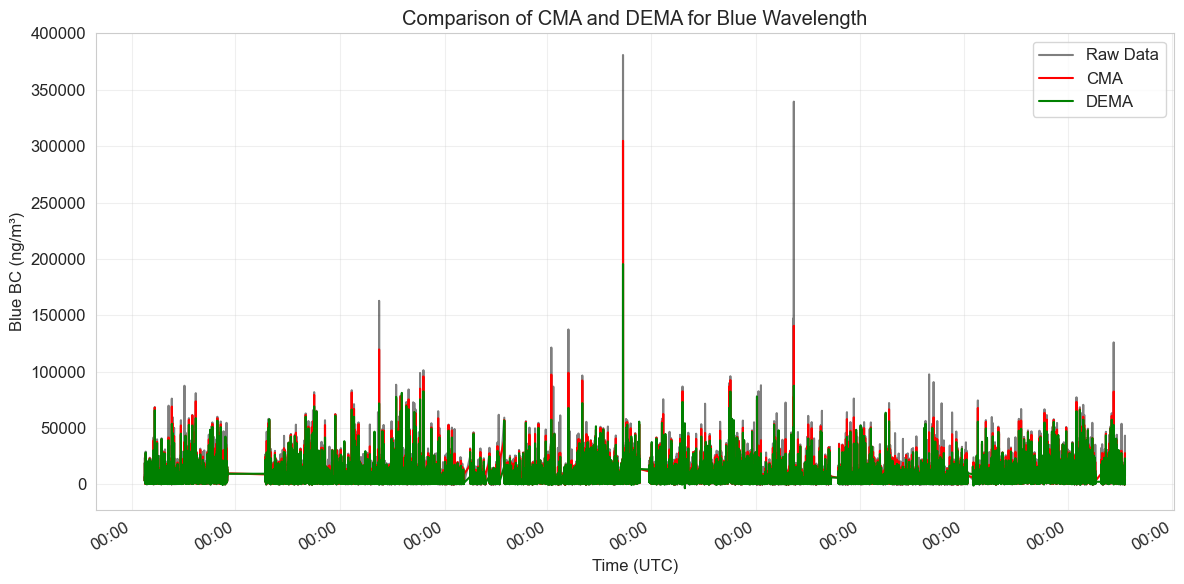


Zoomed view of first 1000 points:


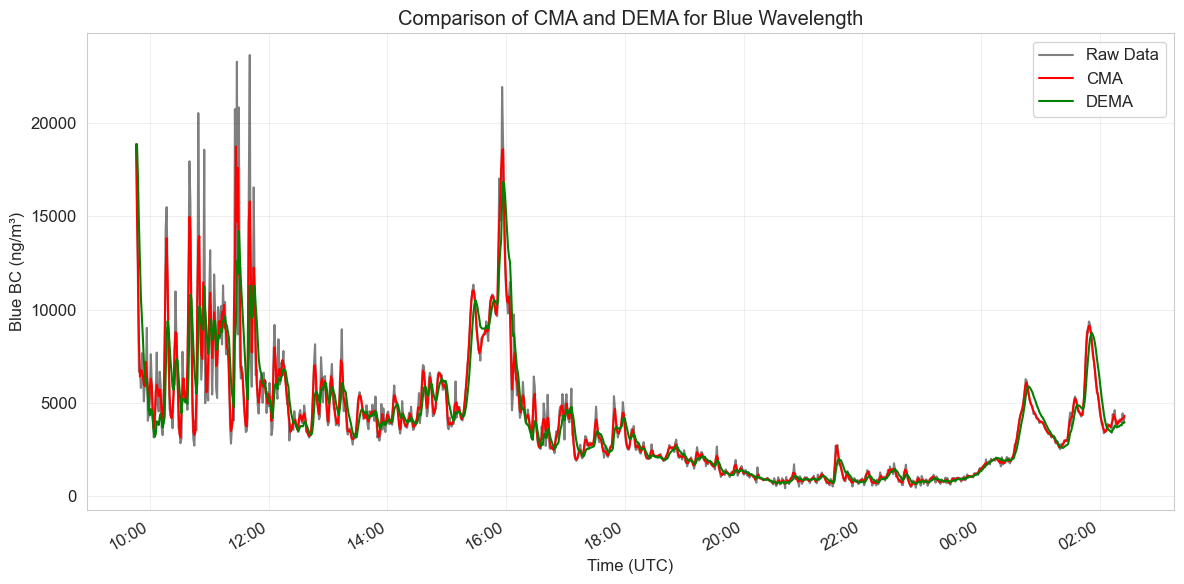


Plots for IR wavelength comparison:


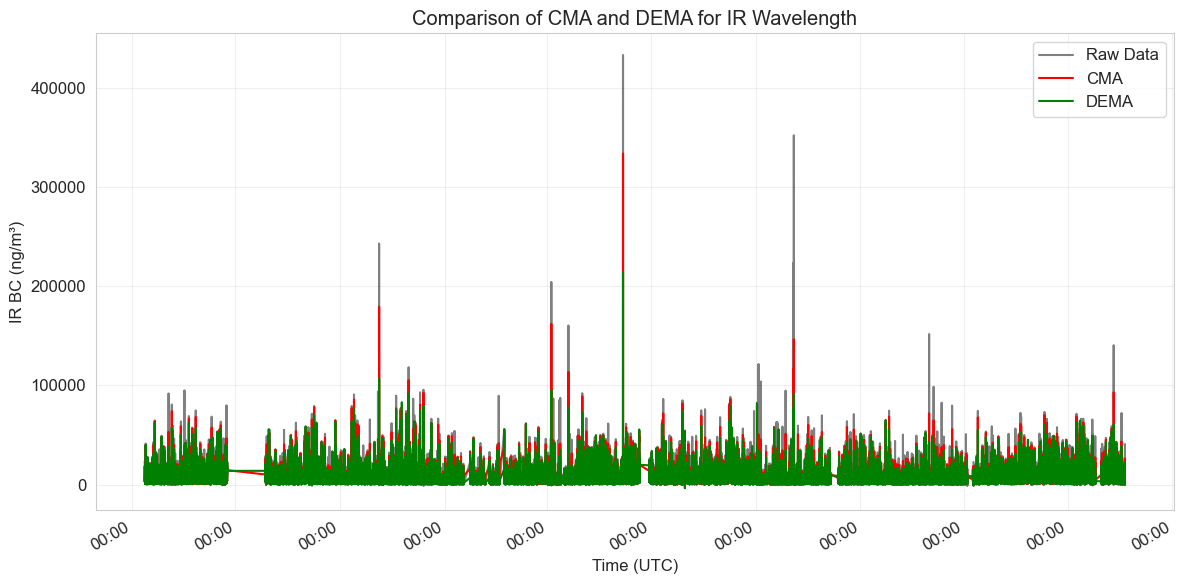


Zoomed view of first 1000 points:


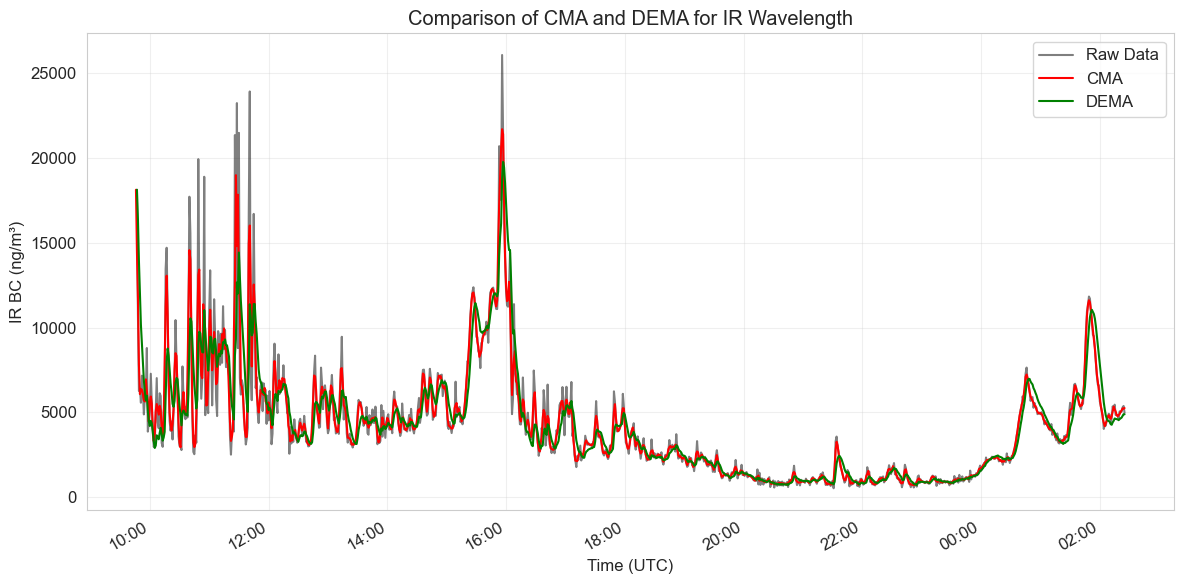


Source apportionment comparison plots:


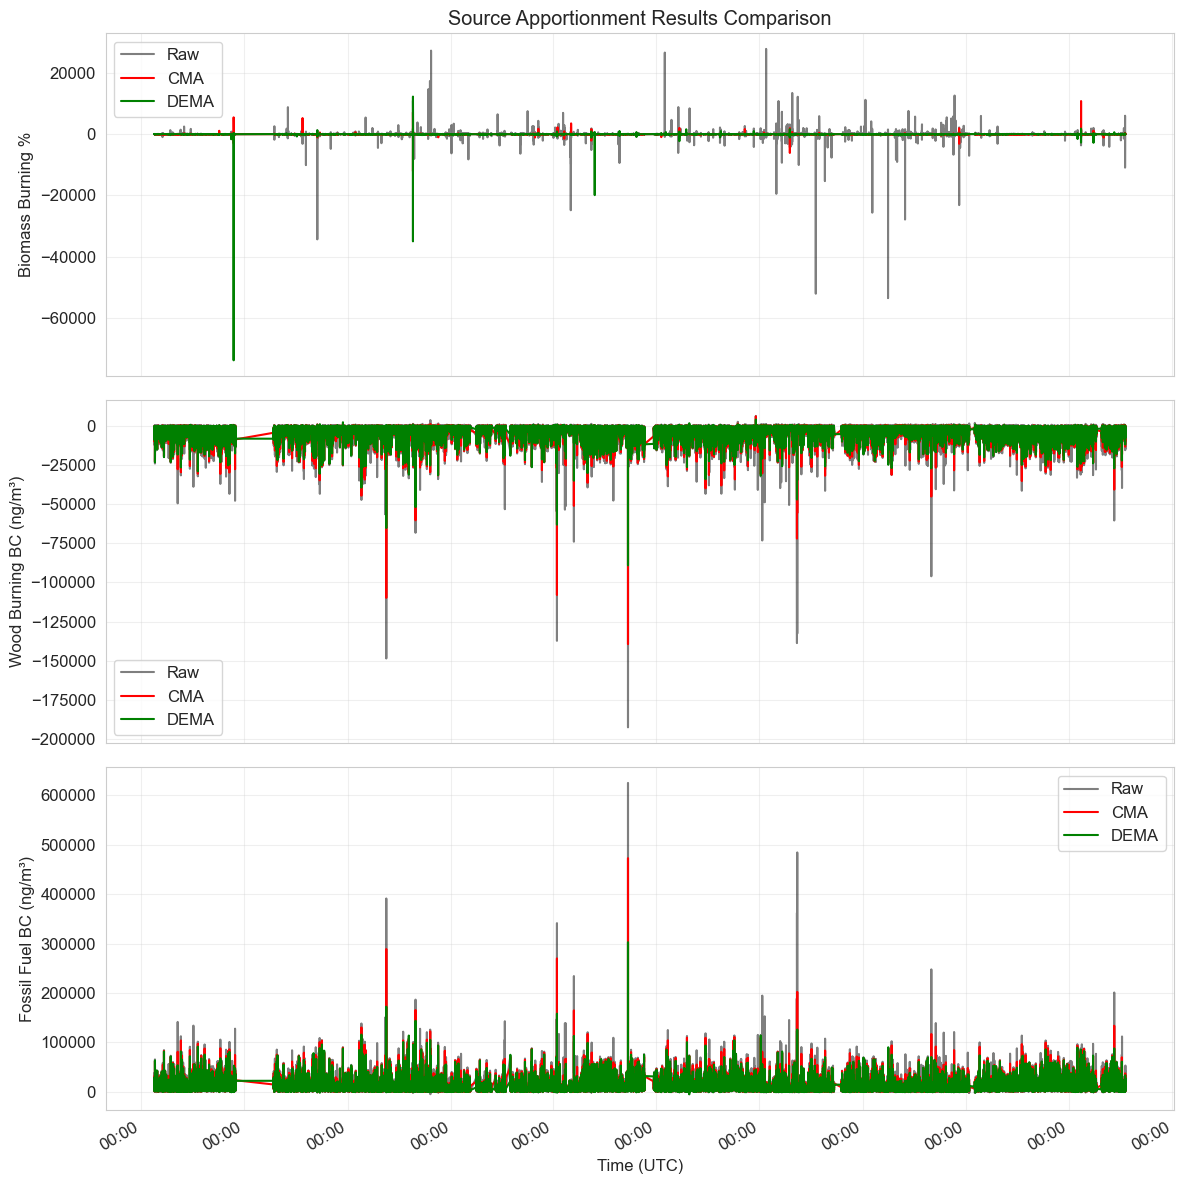


Zoomed view of first 1000 points:


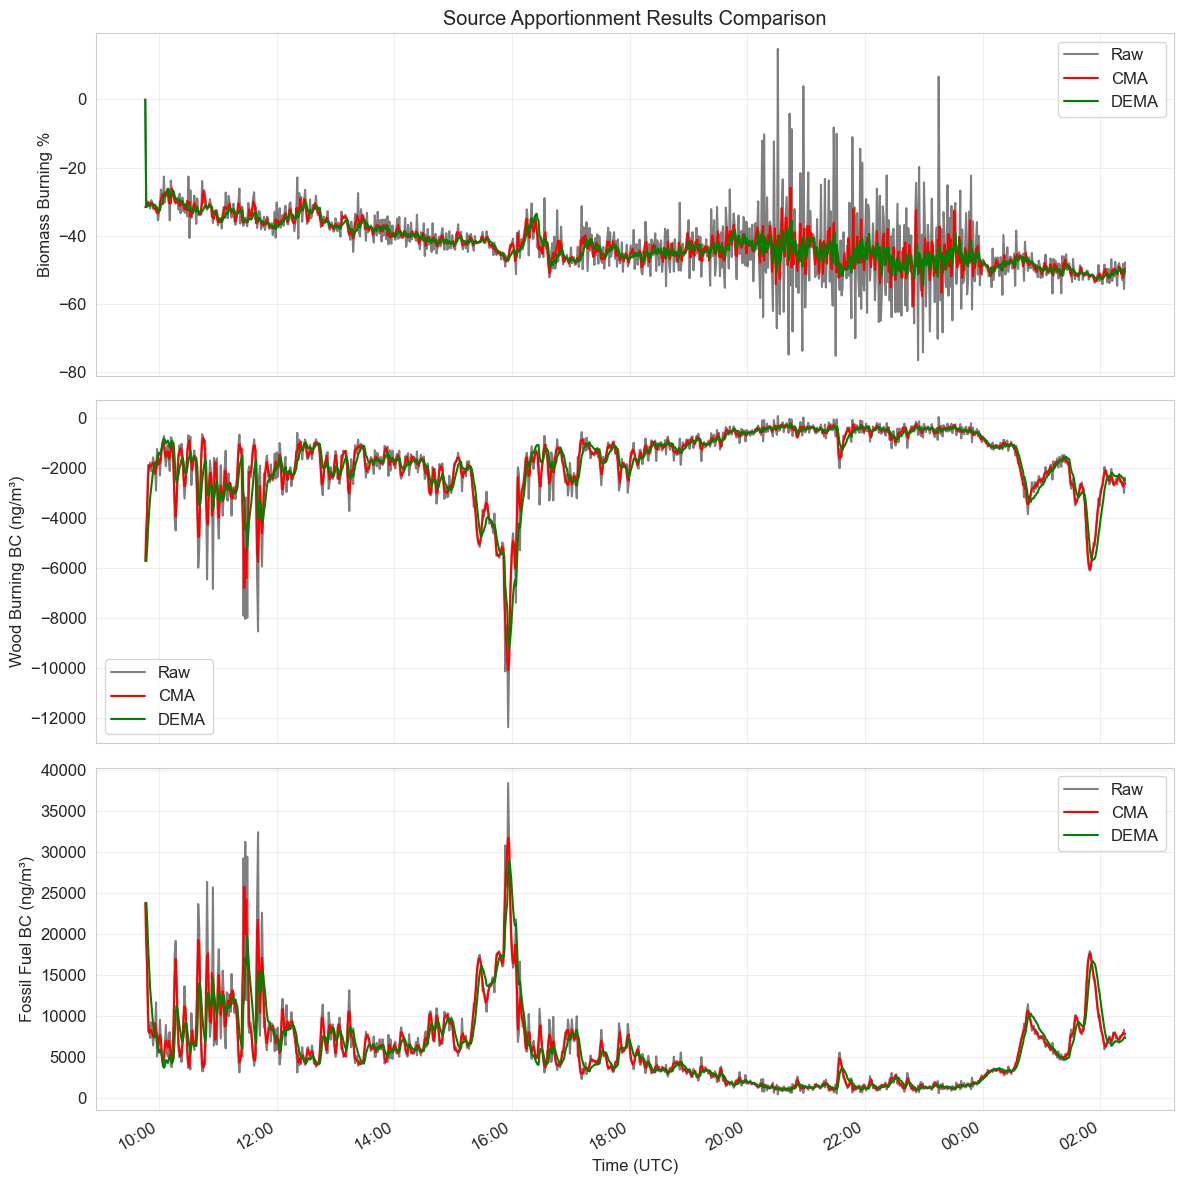

In [10]:
def plot_source_apportionment_comparison(data_raw, data_cma, data_dema, sample_period=None):
    """
    Plot the source apportionment results for raw, CMA and DEMA data
    
    Parameters:
    -----------
    data_raw : pandas.DataFrame
        DataFrame with raw source apportionment data
    data_cma : pandas.DataFrame
        DataFrame with CMA processed source apportionment data
    data_dema : pandas.DataFrame
        DataFrame with DEMA processed source apportionment data
    sample_period : tuple, optional
        Start and end indices for a subset of the data to plot
    """
    # Select a subset of data if specified
    if sample_period is not None:
        start_idx, end_idx = sample_period
        plot_data_raw = data_raw.iloc[start_idx:end_idx].copy()
        plot_data_cma = data_cma.iloc[start_idx:end_idx].copy()
        plot_data_dema = data_dema.iloc[start_idx:end_idx].copy()
    else:
        plot_data_raw = data_raw.copy()
        plot_data_cma = data_cma.copy()
        plot_data_dema = data_dema.copy()
    
    # Create x-axis values
    if 'Time (UTC)' in plot_data_raw.columns:
        try:
            x = pd.to_datetime(plot_data_raw['Time (UTC)'])
            x_formatter = mdates.DateFormatter('%H:%M')
            x_label = 'Time (UTC)'
        except:
            x = np.arange(len(plot_data_raw))
            x_label = 'Data Point'
    else:
        x = np.arange(len(plot_data_raw))
        x_label = 'Data Point'
    
    # Create a figure with three subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
    
    # Plot BB percentage
    axes[0].plot(x, plot_data_raw['BB_Percent'], 'k-', alpha=0.5, label='Raw')
    axes[0].plot(x, plot_data_cma['BB_Percent'], 'r-', label='CMA')
    axes[0].plot(x, plot_data_dema['BB_Percent'], 'g-', label='DEMA')
    axes[0].set_ylabel('Biomass Burning %')
    axes[0].set_title('Source Apportionment Results Comparison')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot Wood Burning BC
    axes[1].plot(x, plot_data_raw['BC_WB'], 'k-', alpha=0.5, label='Raw')
    axes[1].plot(x, plot_data_cma['BC_WB'], 'r-', label='CMA')
    axes[1].plot(x, plot_data_dema['BC_WB'], 'g-', label='DEMA')
    axes[1].set_ylabel('Wood Burning BC (ng/m³)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot Fossil Fuel BC
    axes[2].plot(x, plot_data_raw['BC_FF'], 'k-', alpha=0.5, label='Raw')
    axes[2].plot(x, plot_data_cma['BC_FF'], 'r-', label='CMA')
    axes[2].plot(x, plot_data_dema['BC_FF'], 'g-', label='DEMA')
    axes[2].set_ylabel('Fossil Fuel BC (ng/m³)')
    axes[2].set_xlabel(x_label)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    if x_label == 'Time (UTC)':
        for ax in axes:
            ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()
    
    plt.tight_layout()
    plt.show()

# Plot comparison for each wavelength
for wavelength in ['Blue', 'IR']:
    bc_col = f"{wavelength} BC1"
    cma_col = f"{wavelength}_BC_CMA"
    dema_col = f"{wavelength}_BC_DEMA"
    
    if all(col in df.columns for df, col in zip(
            [data, processed_data_cma, processed_data_dema], 
            [bc_col, cma_col, dema_col])):
        print(f"\nPlots for {wavelength} wavelength comparison:")
        
        # Plot full dataset
        plot_comparison(data, processed_data_cma, processed_data_dema, wavelength)
        
        # Plot a sample period (first 1000 points or 10% of data, whichever is smaller)
        sample_size = min(1000, int(len(data) * 0.1))
        if sample_size < len(data):
            print(f"\nZoomed view of first {sample_size} points:")
            plot_comparison(data, processed_data_cma, processed_data_dema, wavelength, (0, sample_size))

# Plot source apportionment comparisons
print("\nSource apportionment comparison plots:")
plot_source_apportionment_comparison(processed_data_raw, processed_data_cma_sa, processed_data_dema_sa)

# Plot a sample period
sample_size = min(1000, int(len(data) * 0.1))
if sample_size < len(data):
    print(f"\nZoomed view of first {sample_size} points:")
    plot_source_apportionment_comparison(processed_data_raw, processed_data_cma_sa, processed_data_dema_sa, (0, sample_size))
